Adding css style to the following notebook file:

In [1]:
heading = '''
h3 {
    color: white;
    background-color: black;
    padding: 0.5em;
}
'''

In [2]:
table = '''
body {
    margin: 0;
    font-family: Helvetica;
}
table.dataframe {
    border-collapse: collapse;
    border: none;
}
table.dataframe tr {
    border: none;
}
table.dataframe td, table.dataframe th {
    margin: 0;
    border: 1px solid white;
    padding-left: 0.25em;
    padding-right: 0.25em;
}
table.dataframe th:not(:empty) {
    background-color: #fec;
    text-align: left;
    font-weight: normal;
}
table.dataframe tr:nth-child(2) th:empty {
    border-left: none;
    border-right: 1px dashed #888;
}
table.dataframe td {
    border: 2px solid #ccf;
    background-color: #f4f4ff;
}
'''

In [3]:
from IPython.core.display import HTML

css = heading + table
HTML('<style>{}</style>'.format(css))


### Author: Ramprasath Karunakaran

Date written: 24/08/2016

Version: 1.0

Program: Python 2.7.12 and Jupyter notebook


In [4]:
#checking python version
!python --version

Python 2.7.12 :: Anaconda 4.1.1 (x86_64)


In [5]:
#importing required libraries
import pandas as pd
import re
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Loading the dataset 

In [6]:
#loading the dataset
disaster_df = pd.read_csv('Data.csv',header=None,skiprows=0)
disaster_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,NaN,Start,End,Country,Location,Type,Sub_Type,Names,Killed,Affected,Cost,International support,ID,Impact_area
1,0.0,10061965,10061965,Japan,NaN,Storm,Tropical cyclone,Dinah,61.0,30000.0,NaN,1934.944,1965-0036,1074.46
2,1.0,8092004,8092004,Grenada,NaN,Storm,Tropical cyclone,Ivan,39.0,60000.0,889.0,1090.83,2004-0462,2162.03
3,2.0,15031995,15031995,Russia,Kalmoukie:Daghestan (Mer ...,Transport Accident,Water,NaN,52.0,NaN,NaN,NaN,1995-0362,NaN
4,3.0,21983,21983,Cuba,Santiago de Cuba:Pinar d ...,Flood,NaN,NaN,15.0,164575.0,60.0,905.275,1983-0042,5893.45


Problems noted from the above dataframe:
> - Columns are unnamed and the headers can be located in the first row.
- First unnamed column is an additional index column.
- Columns Start and End are the dates of the disasters but they are poorly formatted
- Some dates have only month and year and some have year alone.
- Location column does not have proper format and is not consistent.(Example: 'au large de' is French for 'Off the coast of')

### Removing the additional index column and re-indexing

In [7]:
#Dropping the additional index column
disaster_df.drop(0,1,inplace=True)

In [8]:
#Making the first row as column headers and then dropping them
disaster_df.columns = disaster_df.iloc[0]
disaster_alterdf = disaster_df.reindex(disaster_df.index.drop(0))

### Finding the shape, datatype and statistics for the dataframe

In [9]:
#Finding the datatypes of each column in the dataframe
disaster_alterdf.dtypes

0
Start                    object
End                      object
Country                  object
Location                 object
Type                     object
Sub_Type                 object
Names                    object
Killed                   object
Affected                 object
Cost                     object
International support    object
ID                       object
Impact_area              object
dtype: object

In [10]:
#Converting the datatype for numeric data columns
disaster_alterdf[['Killed','Affected','Cost','International support','Impact_area']]=disaster_alterdf[['Killed','Affected','Cost','International support','Impact_area']].apply(pd.to_numeric)
disaster_alterdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14350 entries, 1 to 14350
Data columns (total 13 columns):
Start                    14350 non-null object
End                      14350 non-null object
Country                  14350 non-null object
Location                 12458 non-null object
Type                     14350 non-null object
Sub_Type                 12515 non-null object
Names                    4558 non-null object
Killed                   11301 non-null float64
Affected                 8884 non-null float64
Cost                     3027 non-null float64
International support    6928 non-null float64
ID                       14350 non-null object
Impact_area              6928 non-null float64
dtypes: float64(5), object(8)
memory usage: 1.5+ MB


In [11]:
#Determining the number of rows and columns
disaster_alterdf.shape

(14350, 13)

In [12]:
#Looking at the statistics for numeric data
disaster_alterdf.describe()

/Users/iRam/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,Killed,Affected,Cost,International support,Impact_area
count,1.130100e+04,8.884000e+03,3027.000000,6928.000000,6.928000e+03
mean,2.802027e+03,5.915656e+05,482.783997,1014.587596,1.955000e+04
std,7.755262e+04,7.240275e+06,3319.931382,446.295287,2.348441e+05
min,1.000000e+00,1.000000e+00,0.003000,0.000000,0.000000e+00
25%,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN
max,5.000000e+06,3.000000e+08,125000.000000,2801.093000,1.073480e+07


In [13]:
#Making a copy of the original dataset. disaster_alterdf will be used for all the operations
originaldisasterdf = disaster_alterdf.copy()

### Changing the format of Start and End Date columns
This is an instance of Irregularity of the data. The data format of these two columns can fixed using the method below.

In [14]:
#This function parses the date and converts it to the format(dd-mm-yyyy)
def convertdate(date):
    if len(date) == 4:
        return date
    elif len(date) < 7:
        return date[: -4].zfill(2) + '-' + date[-4: ]
    elif len(date) >= 7:
        return date[: -6].zfill(2) + '-' + date[-6: -4].zfill(2) + '-' + date[-4:]
    else:
        return None
    
#Applying the above function over the Start and End columns
disaster_alterdf.Start=disaster_alterdf.Start.apply(convertdate)
disaster_alterdf.End=disaster_alterdf.End.apply(convertdate)
disaster_alterdf

,Start,End,Country,Location,Type,Sub_Type,Names,Killed,Affected,Cost,International support,ID,Impact_area
1,10-06-1965,10-06-1965,Japan,NaN,Storm,Tropical cyclone,Dinah,61.0,30000.0,NaN,1934.944,1965-0036,1074.46
2,08-09-2004,08-09-2004,Grenada,NaN,Storm,Tropical cyclone,Ivan,39.0,60000.0,889.000,1090.830,2004-0462,2162.03
3,15-03-1995,15-03-1995,Russia,Kalmoukie:Daghestan (Mer ...,Transport Accident,Water,NaN,52.0,NaN,NaN,NaN,1995-0362,NaN
4,02-1983,02-1983,Cuba,Santiago de Cuba:Pinar d ...,Flood,NaN,NaN,15.0,164575.0,60.000,905.275,1983-0042,5893.45
5,1983,1983,Nepal,NaN,Mass movement wet,Landslide,NaN,21.0,NaN,NaN,NaN,1983-0526,NaN
6,26-07-1996,26-07-1996,Russia,Volgorgrad,Industrial Accident,Gas Leak,Oil refinery,NaN,NaN,NaN,NaN,1996-0209,NaN
7,19-06-2003,19-06-2003,Turkey,Kayseri,Miscellaneous accident,Explosion,Dormitory of a school,10.0,13.0,NaN,824.806,2003-0296,5.29
8,16-02-2003,22-02-2003,Pakistan,Baluchistan:Sindh:North ...,Storm,NaN,NaN,51.0,2557.0,NaN,992.690,2003-0086,130.70
9,08-1986,08-1986,Honduras,Northeast Honduras/Mosqui ...,Flood,NaN,NaN,NaN,30000.0,NaN,NaN,1986-0093,NaN
10,13-10-2007,13-10-2007,Colombia,Near Suarez (Cauca),Industrial Accident,Collapse,Cold mine,22.0,24.0,NaN,888.882,2007-0500,31.56


Now we have to deal with all the integrity constraints such as start date being greater than end date and a month having invalid date(September having 31 days rather than 30 days.)

In [15]:
# Function to convert the string to date
def to_date(startdate,dateformat):
    string = dt.datetime.strptime(startdate, dateformat).date()
    return string

In [18]:
# Function to return the date format based on length of the string
def date_format(date):
    if date==4:
        dateformat = "%Y"#date with year alone
    elif date==7:
        dateformat = "%M-%Y" #date with month and year
    elif date==10:
        dateformat = "%d-%m-%Y" # a complete date
    else:    
        print 'Unknown'
    return  dateformat  

In [19]:
#Function to find invalid dates 
for i in disaster_alterdf.itertuples():
    try: 
        mindate = min(len(i[1]),len(i[2])) # Finding the minimum of two dates  
        #converting the dates to date format using the above two functions
        start = to_date(i[1][-mindate:], date_format(mindate)) 
        end = to_date(i[2][-mindate:], date_format(mindate))
        #if the start date is after the end date(integrity constraint)
        if start>end:
            print "Integrity constraint violation "+str(i[0])+' '+str(start)+' '+str(end)+' '+i[3]+' '+i[4]+' '+i[5]+' '+i[6]+' '+str(i[7])+' '+str(i[8])

    except (ValueError):
            string = 'Invalid Dates '+str(i[0])+' '+str(i[1])+' '+str(i[2])+' '+str(i[3])+' '+str(i[4])+' '+str(i[5])+' '+str(i[6])+' '+str(i[7])
            print string
            pass



Invalid Dates 111 08-09-1992 31-09-1992 India Uttar Pradesh:Jammu:Mad ... Flood General flood nan
Integrity constraint violation 4322 1997-01-01 1989-01-01 Viet Nam Quang Tri:Quang Binh:Qu ... Drought Drought nan nan
Integrity constraint violation 5468 2007-03-31 2007-03-29 New Zealand Bay of Islands area Storm Tropical cyclone Becky nan
Integrity constraint violation 5822 1972-01-01 1957-01-01 Benin Entire country Drought Drought nan nan
Invalid Dates 8420 31-09-1992 31-09-1992 Afghanistan Salang:Ghorband:Shutul  ... Flood Flash flood nan
Invalid Dates 12068 01-01-1998 31-02-1998 Peru Arequipa:Lima:La Libert ... Epidemic Bacterial Infectious Diseases Cholera


Since we have only 6 invalid full dates. We can choose to impute the dates manually by searching online using the other details of the disaster.

### Bringing to date time format

For Start Dates:
> -	If the month was "00", month will be set to "01"
- If the day was "00", day will be set to "01"
- If the day was greater than the days in the month, the last day of the month will be set.

For End Dates:
> -	If the month is "00" set the month to "12"
- If the day is "00" set to the last day of the month
- If the day is greater than the days in the month, set to the last day of the month


In [20]:
# Dictionary that specifies the number of days in each month
monthdictionary = {"01":"31", "02":"28", "03":"31", "04":"30", "05":"31", "06":"30",
             "07":"31", "08":"31", "09":"30", "10":"31", "11":"30", "12":"31"}

In [21]:
# Function to convert dates to a valid date in ddmmyyyy format
def fixDate(value, useMax=False):
    if len(value) < 10:
        value = to_date(value,date_format(len(value))) 
        value = value.strftime("%d-%m-%Y")

    day = value[0:2]                                  # Extract the day component 
    month = value[3:5]                                # Extract the month component
    year = value[6:10]                                # Extract the year component    

    if month == "00":                                 # If the month is "00" ... 
        month = "12" if useMax else "01"              # Correct the month dependig on the the useMax flag
        value = day +'-'+ month+'-'+year              # Date value to return

    if day == "00":                                   # If the day is "00" ... 
        day = monthdictionary[month] if useMax else "01"    # Correct the day depending on the useMax flag
        value = day +'-'+ month+'-'+year              # Date value to return

    try:
        dt.datetime.strptime(value, "%d-%m-%Y")       # Check the date is valid
    except:                                           # If not, the day must still be invalid
        day = monthdictionary[month]                        # Set to the last day of the month
        value = day +'-'+ month+'-'+year              # Date value to return
        dt.datetime.strptime(value, "%d-%m-%Y").date()      # Verify the date is now valid

    return value                                      # Return the fixed date

In [22]:
# Fix invalid dates in the Start column
disaster_alterdf["Start"] = disaster_alterdf.Start.apply(fixDate)
# Convert the Start column to datetime format
disaster_alterdf["Start"] = pd.to_datetime(disaster_alterdf["Start"], format="%d-%m-%Y")
# Fix invalid dates in the End column
disaster_alterdf["End"] = disaster_alterdf.End.apply(fixDate, useMax=True)
# Convert the End column to datetime format
disaster_alterdf["End"] = pd.to_datetime(disaster_alterdf["End"], format="%d-%m-%Y")

In [25]:
#looking at the data types
disaster_alterdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14350 entries, 1 to 14350
Data columns (total 13 columns):
Start                    14350 non-null datetime64[ns]
End                      14350 non-null datetime64[ns]
Country                  14350 non-null object
Location                 12458 non-null object
Type                     14350 non-null object
Sub_Type                 12515 non-null object
Names                    4558 non-null object
Killed                   11301 non-null float64
Affected                 8884 non-null float64
Cost                     3027 non-null float64
International support    6928 non-null float64
ID                       14350 non-null object
Impact_area              6928 non-null float64
dtypes: datetime64[ns](2), float64(5), object(6)
memory usage: 1.5+ MB


### Cleaning Country column
To check if all countries in the 'Country' column are valid, we add a list adapted from this [link](https://www.sitekickr.com/snippets/python/list-countries) and use them for validation.

In [ ]:
# List of countries with codes
countrieslist = [
    ('US', 'United States'),
    ('AF', 'Afghanistan'),
    ('AL', 'Albania'),
    ('DZ', 'Algeria'),
    ('AS', 'American Samoa'),
    ('AD', 'Andorra'),
    ('AO', 'Angola'),
    ('AI', 'Anguilla'),
    ('AQ', 'Antarctica'),
    ('AG', 'Antigua And Barbuda'),
    ('AR', 'Argentina'),
    ('AM', 'Armenia'),
    ('AW', 'Aruba'),
    ('AU', 'Australia'),
    ('AT', 'Austria'),
    ('AZ', 'Azerbaijan'),
    ('BS', 'Bahamas'),
    ('BH', 'Bahrain'),
    ('BD', 'Bangladesh'),
    ('BB', 'Barbados'),
    ('BY', 'Belarus'),
    ('BE', 'Belgium'),
    ('BZ', 'Belize'),
    ('BJ', 'Benin'),
    ('BM', 'Bermuda'),
    ('BT', 'Bhutan'),
    ('BO', 'Bolivia'),
    ('BA', 'Bosnia And Herzegovina'),
    ('BW', 'Botswana'),
    ('BV', 'Bouvet Island'),
    ('BR', 'Brazil'),
    ('BN', 'Brunei Darussalam'),
    ('BG', 'Bulgaria'),
    ('BF', 'Burkina Faso'),
    ('BI', 'Burundi'),
    ('KH', 'Cambodia'),
    ('CM', 'Cameroon'),
    ('CA', 'Canada'),
    ('CV', 'Cape Verde'),
    ('KY', 'Cayman Islands'),
    ('CF', 'Central African Rep'),
    ('TD', 'Chad'),
    ('CL', 'Chile'),
    ('CN', 'China'),
    ('CX', 'Christmas Island'),
    ('CC', 'Cocos Islands'),
    ('CO', 'Colombia'),
    ('KM', 'Comoros'),
    ('CG', 'Congo'),
    ('CK', 'Cook Islands'),
    ('CR', 'Costa Rica'),
    ('CI', 'Cote dIvoire'),
    ('HR', 'Croatia'),
    ('CU', 'Cuba'),
    ('CY', 'Cyprus'),
    ('CZ', 'Czech Republic'),
    ('CSSR','Czechoslovakia'),
    ('DK', 'Denmark'),
    ('DJ', 'Djibouti'),
    ('DM', 'Dominica'),
    ('DO', 'Dominican Republic'),
    ('TP', 'East Timor'),
    ('EC', 'Ecuador'),
    ('EG', 'Egypt'),
    ('SV', 'El Salvador'),
    ('GQ', 'Equatorial Guinea'),
    ('ER', 'Eritrea'),
    ('EE', 'Estonia'),
    ('ET', 'Ethiopia'),
    ('FK', 'Falkland Islands (Malvinas)'),
    ('FO', 'Faroe Islands'),
    ('FJ', 'Fiji'),
    ('FI', 'Finland'),
    ('FR', 'France'),
    ('GF', 'French Guiana'),
    ('PF', 'French Polynesia'),
    ('TF', 'French S. Territories'),
    ('GA', 'Gabon'),
    ('GM', 'Gambia'),
    ('GE', 'Georgia'),
    ('DE', 'Germany'),
    ('GH', 'Ghana'),
    ('GI', 'Gibraltar'),
    ('GR', 'Greece'),
    ('GL', 'Greenland'),
    ('GD', 'Grenada'),
    ('GP', 'Guadeloupe'),
    ('GU', 'Guam'),
    ('GT', 'Guatemala'),
    ('GN', 'Guinea'),
    ('GW', 'Guinea-bissau'),
    ('GY', 'Guyana'),
    ('HT', 'Haiti'),
    ('HN', 'Honduras'),
    ('HK', 'Hong Kong'),
    ('HU', 'Hungary'),
    ('IS', 'Iceland'),
    ('IN', 'India'),
    ('ID', 'Indonesia'),
    ('IR', 'Iran'),
    ('IQ', 'Iraq'),
    ('IE', 'Ireland'),
    ('IL', 'Israel'),
    ('IT', 'Italy'),
    ('JM', 'Jamaica'),
    ('JP', 'Japan'),
    ('JO', 'Jordan'),
    ('KZ', 'Kazakhstan'),
    ('KE', 'Kenya'),
    ('KI', 'Kiribati'),
    ('KOR','Korea'),
    ('KP', 'Korea (North)'),
    ('KR', 'Korea (South)'),
    ('KW', 'Kuwait'),
    ('KG', 'Kyrgyzstan'),
    ('LA', 'Laos'),
    ('LV', 'Latvia'),
    ('LB', 'Lebanon'),
    ('LS', 'Lesotho'),
    ('LR', 'Liberia'),
    ('LY', 'Libya'),
    ('LI', 'Liechtenstein'),
    ('LT', 'Lithuania'),
    ('LU', 'Luxembourg'),
    ('MO', 'Macau'),
    ('MK', 'Macedonia'),
    ('MG', 'Madagascar'),
    ('MW', 'Malawi'),
    ('MY', 'Malaysia'),
    ('MV', 'Maldives'),
    ('ML', 'Mali'),
    ('MT', 'Malta'),
    ('MH', 'Marshall Islands'),
    ('MQ', 'Martinique'),
    ('MR', 'Mauritania'),
    ('MU', 'Mauritius'),
    ('YT', 'Mayotte'),
    ('MX', 'Mexico'),
    ('FM', 'Micronesia'),
    ('MD', 'Moldova'),
    ('MC', 'Monaco'),
    ('MN', 'Mongolia'),
    ('MS', 'Montserrat'),
    ('MA', 'Morocco'),
    ('MZ', 'Mozambique'),
    ('MM', 'Myanmar'),
    ('NA', 'Namibia'),
    ('NR', 'Nauru'),
    ('NP', 'Nepal'),
    ('NL', 'Netherlands'),
    ('AN', 'Netherlands Antilles'),
    ('NC', 'New Caledonia'),
    ('NZ', 'New Zealand'),
    ('NI', 'Nicaragua'),
    ('NE', 'Niger'),
    ('NG', 'Nigeria'),
    ('NU', 'Niue'),
    ('NF', 'Norfolk Island'),
    ('MP', 'Northern Mariana Islands'),
    ('NO', 'Norway'),
    ('OM', 'Oman'),
    ('PK', 'Pakistan'),
    ('PW', 'Palau'),
    ('PS', 'Palestine'),
    ('PA', 'Panama'),
    ('PG', 'Papua New Guinea'),
    ('PY', 'Paraguay'),
    ('PE', 'Peru'),
    ('PH', 'Philippines'),
    ('PN', 'Pitcairn'),
    ('PL', 'Poland'),
    ('PT', 'Portugal'),
    ('PR', 'Puerto Rico'),
    ('QA', 'Qatar'),
    ('RE', 'Reunion'),
    ('RO', 'Romania'),
    ('RU', 'Russia'),
    ('RW', 'Rwanda'),
    ('KN', 'Saint Kitts And Nevis'),
    ('LC', 'Saint Lucia'),
    ('VC', 'St Vincent and The Grenadines'),
    ('WS', 'Samoa'),
    ('SM', 'San Marino'),
    ('ST', 'Sao Tome'),
    ('SA', 'Saudi Arabia'),
    ('SN', 'Senegal'),
    ('SC', 'Seychelles'),
    ('SL', 'Sierra Leone'),
    ('SAM','Serbia Montenegro'),
    ('SG', 'Singapore'),
    ('SK', 'Slovakia'),
    ('SI', 'Slovenia'),
    ('SB', 'Solomon Islands'),
    ('SO', 'Somalia'),
    ('SU', 'Soviet Union'),
    ('ZA', 'South Africa'),
    ('ES', 'Spain'),
    ('LK', 'Sri Lanka'),
    ('SH', 'St Helena'),
    ('PM', 'St Pierre'),
    ('LA', 'St Lucia'),
    ('KN', 'St Kitts and Nevis'),
    ('SD', 'Sudan'),
    ('SR', 'Suriname'),
    ('SZ', 'Swaziland'),
    ('SE', 'Sweden'),
    ('CH', 'Switzerland'),
    ('SY', 'Syrian Arab Republic'),
    ('TW', 'Taiwan'),
    ('TJ', 'Tajikistan'),
    ('TZ', 'Tanzania'),
    ('TH', 'Thailand'),
    ('TL', 'Timor-Leste'),
    ('TG', 'Togo'),
    ('TK', 'Tokelau'),
    ('TO', 'Tonga'),
    ('TT', 'Trinidad And Tobago'),
    ('TN', 'Tunisia'),
    ('TR', 'Turkey'),
    ('TM', 'Turkmenistan'),
    ('TC', 'Turks and Caicos Islands'),
    ('TV', 'Tuvalu'),
    ('UG', 'Uganda'),
    ('UA', 'Ukraine'),
    ('AE', 'United Arab Emirates'),
    ('UK', 'United Kingdom'),
    ('UY', 'Uruguay'),
    ('UZ', 'Uzbekistan'),
    ('VU', 'Vanuatu'),
    ('VA', 'Vatican City State'),
    ('VE', 'Venezuela'),
    ('VN', 'Viet Nam'),
    ('VG', 'Virgin Islands (British)'),
    ('VI', 'Virgin Islands (U.S.)'),
    ('EH', 'Western Sahara'),
    ('YE', 'Yemen'),
    ('YU', 'Yugoslavia'),
    ('ZR', 'Zaire'),
    ('ZM', 'Zambia'),
    ('ZW', 'Zimbabwe')
]

#Sort the list 
countrieslist.sort(lambda x,y:cmp(x[1], y[1]))
# Insert missing countries to the list
countrieslist.insert(0,('US',(u'United States'))) 
# Extract the country names to match the values with country column
countrieslist=[re.sub(r"\w*,\s*","",str(x).translate(None,"()'")) for x in countrieslist]

In [ ]:
from collections import Counter
# To identify the inconsistent and lexical error values
invalidcountry=[]
for i in disaster_alterdf.Country:
    if i not in countrieslist:
        value = str(i)
        invalidcountry.append(value)
        
# Count the invalid entries after matching
count = Counter(invalidcountry)        
print count

This is the list of all the invalid entries for 'Country' column.

In [ ]:
# Defining correct values for the wrong entries in country column
country_lookup={
"Bosnia And Herzegovina":["Bosnia-Hercegovenia"],
"Spain":["Canary Is"],
"Cape Verde":["Cape Verde Is Is"],
"Cook Islands":["Cook Is"],
"China":["Chine","China P Rep","Hong Kong (China)"],
"Dominican Republic":["Dominican Rep"],
"Germany":["Germany Fed Rep","Germany Dem Rep"],
"Gambia":["Gambia The"],
"Iran":["Iran Islam Rep"],
"Korea":["Korea Dem P Rep","Korea Rep"],
"Laos":["Lao P Dem Rep"],
"Libya":["Libyan Arab Jamah"],
"Macedonia":["Macedonia FRY"],
"Marshall Islands":["Marshall Is"],
"Micronesia":["Micronesia Fed States"],
"Moldova":["Moldova Rep"],
"Northern Mariana Islands":["Northern Mariana Is"],
"Palestine":["Palestine (West Bank)"],
"Sao Tome":["Sao Tome et Principe"],
"Solomon Islands":["Solomon Is"],
"Syrian Arab Republic":["Syrian Arab Rep"],
"Taiwan":["Taiwan (China)"],
"Tanzania":["Tanzania Uni Rep"],
"Turks and Caicos Islands":["Turks and Caicos Is"],
"United States":["USA","United Stats"],
"Virgin Islands U.S":["Virgin Is (US)"],
"Virgin Islands U.K" :["Virgin Is (UK)"],   
"Wallis and Futuna":["Wallis","Wallis and Futuna Is"],
"Yemen":["Yemen Arab Rep","Yemen P Dem Rep"],
"Zaire":["Zaire/Congo Dem Rep"]
    }

# Function to translate the error values into valid country names
def replacecountry(wrongvalue):
    rightvalue = wrongvalue
    for k, v in country_lookup.iteritems():
        if rightvalue in v:
            rightvalue = k
    return rightvalue

In [ ]:
# apply translate function to all rows in the country column
disaster_alterdf['Country'] = disaster_alterdf['Country'].apply(replacecountry)

### Cleaning Location Column

In [ ]:
disaster_alterdf.Location

Problems noted in the Location column:
> - colon(:) in between strings and it acts as a seperator between locations
- triple dots(...) found in most of the columns
- some data manipulation process would have caused those triple dots(...).Because every instance of triple dots is at the end of the string and the string length is around 20.
- Some locations are in other languages.


In [ ]:
# To replace the colon with comma and to remove dot (.)
locationcleaner = lambda x: x.replace(':',',').translate(None,"\.*\\").strip().rstrip(',')
disaster_alterdf['Location'] = disaster_alterdf.Location.dropna().apply(locationcleaner)
disaster_alterdf.Location

Finding other problems:

In [ ]:
#Finding the amount(%) of missing values
disaster_alterdf.Location.isnull().sum()*100/len(disaster_alterdf.Location)

> - 13% of the locations are missing.
- Some values are encoded in hexadecimal such as '\xc3\xaf\xc2\xbf\xc2\xbd'. They must be in a different language hence they have been encoded.

### Cleaning 'Type' Column

In [ ]:
disaster_alterdf[disaster_alterdf.Type.isnull()]

Points to be noted in Type Column:
> - There are no null values.
- They are of category type. So we will convert them to category datatype

In [ ]:
#changing datatype
disaster_alterdf['Type'] = disaster_alterdf['Type'].astype('category')

In [ ]:
# To count the frequecy of values in the column
types= pd.value_counts(disaster_alterdf['Type'].values, sort=True)
types

From the above list, we can see some inconsistencies such as:
> - Transport Accident and Transport accident
- Mass movement dry and Mass Movement Dry
- Mass movement wet and Mass Movement Wet

In [ ]:
# Making all initial letters uppercase using title() function
typeconversion = lambda x: x.title()
disaster_alterdf['Type'] = disaster_alterdf.Type.apply(typeconversion)

In [ ]:
# To count the frequecy of values in the column
types= pd.value_counts(disaster_alterdf['Type'].values, sort=True)
types

Now, Type column is cleaned and we have discrete set of categories with no inconsistencies.

### Cleaning Sub_Type Column

In [ ]:
# Finding percentage of missing values
disaster_alterdf.Sub_Type.isnull().sum()*100/len(disaster_alterdf.Sub_Type)

12% of data is missing so it is better to impute values for analysis.

In [ ]:
subtypes= pd.value_counts(disaster_alterdf['Sub_Type'].values, sort=True)
subtypes

In [ ]:
#Assign dtype 
disaster_alterdf['Sub_Type'] = disaster_alterdf['Sub_Type'].astype('category')

# Sort the values according to type column
subtypes = disaster_alterdf[['Type','Sub_Type']]
subtypes = subtypes.drop_duplicates()
subtypes = subtypes.sort_values(by=['Type','Sub_Type'])
subtypes

Here also, there are some inconsistencies in the data such as:
> - Flash Flood and Flash flood
- General Flood and General flood
- Storm surge/coastal Flood and Storm surge/coastal flood
- Extratropical cyclone and Extratropical cyclone (winter storm) -> Here it is a different category

In [ ]:
#using title function changing the inconsistencies
convertsubtypes = lambda x: x.replace('(Winter Storm)','').title().strip()
disaster_alterdf['Sub_Type'] = disaster_alterdf.Sub_Type.dropna().apply(convertsubtypes)

In [ ]:
#checking again
subtypes = disaster_alterdf[['Type','Sub_Type']]
subtypes = subtypes.drop_duplicates()
subtypes = subtypes.sort_values(by=['Type','Sub_Type'])
subtypes

Now that the inconsistencies are corrected,still there are missing values in the dataset. If it is affecting the analysis. One way to replace them would be with their respective types in the 'Type' column.

### Finding duplicates in the dataset

In [ ]:
disaster_alterdf[disaster_alterdf.duplicated()==True]

There is only one duplicate when we consider all columns. Let us see the results when we select particular columns.

In [26]:
subset=['Start','End','Country','Location','Type','Sub_Type','Names','Killed','Affected','International support']
disaster_alterdf[disaster_alterdf.duplicated(subset,'last') | disaster_alterdf.duplicated(subset)]

,Start,End,Country,Location,Type,Sub_Type,Names,Killed,Affected,Cost,International support,ID,Impact_area
116,1978-01-01,1978-01-01,United States,NaN,Storm,NaN,NaN,25.0,NaN,NaN,NaN,1978-0258,NaN
323,1980-01-01,1980-01-01,Hong Kong (China),NaN,Wildfire,Scrub/grassland fire,NaN,NaN,NaN,NaN,NaN,1980-0214,NaN
2114,1974-01-01,1974-01-01,Hong Kong (China),NaN,Wildfire,Scrub/grassland fire,NaN,NaN,NaN,NaN,NaN,1974-0117,NaN
4035,1971-01-01,1971-01-01,Hong Kong (China),NaN,Wildfire,Scrub/grassland fire,NaN,NaN,NaN,NaN,NaN,1971-0102,NaN
5022,1972-01-01,1972-01-01,Hong Kong (China),NaN,Wildfire,Scrub/grassland fire,NaN,NaN,NaN,NaN,NaN,1972-0098,NaN
5915,1974-01-01,1974-01-01,Hong Kong (China),NaN,Wildfire,Scrub/grassland fire,NaN,NaN,NaN,NaN,NaN,1974-0115,NaN
6512,1994-05-15,1994-05-15,Brazil,Sao Paulo,Storm,Local storm,NaN,NaN,1000.0,21.0,NaN,1994-0305,NaN
6698,1970-01-01,1970-01-01,Hong Kong (China),NaN,Wildfire,Scrub/grassland fire,NaN,NaN,NaN,NaN,NaN,1970-0094,NaN
7748,1980-01-01,1980-01-01,Hong Kong (China),NaN,Wildfire,Scrub/grassland fire,NaN,NaN,NaN,NaN,NaN,1980-0217,NaN
8696,1971-01-01,1971-01-01,Hong Kong (China),NaN,Wildfire,Scrub/grassland fire,NaN,NaN,NaN,NaN,NaN,1971-0100,NaN


Observations:
> - There are no entirely identical rows but there are some updations in the rows. For example, rows 6512 and 10922 are the same disasters but the Cost column alone has been changed.
- This shows how the data quality of the given dataset has been tampered with.
- This can be solved by adding Last Modified details with the dataset.

### Exploring data using Graphical Exploration methods

### Pair Plot

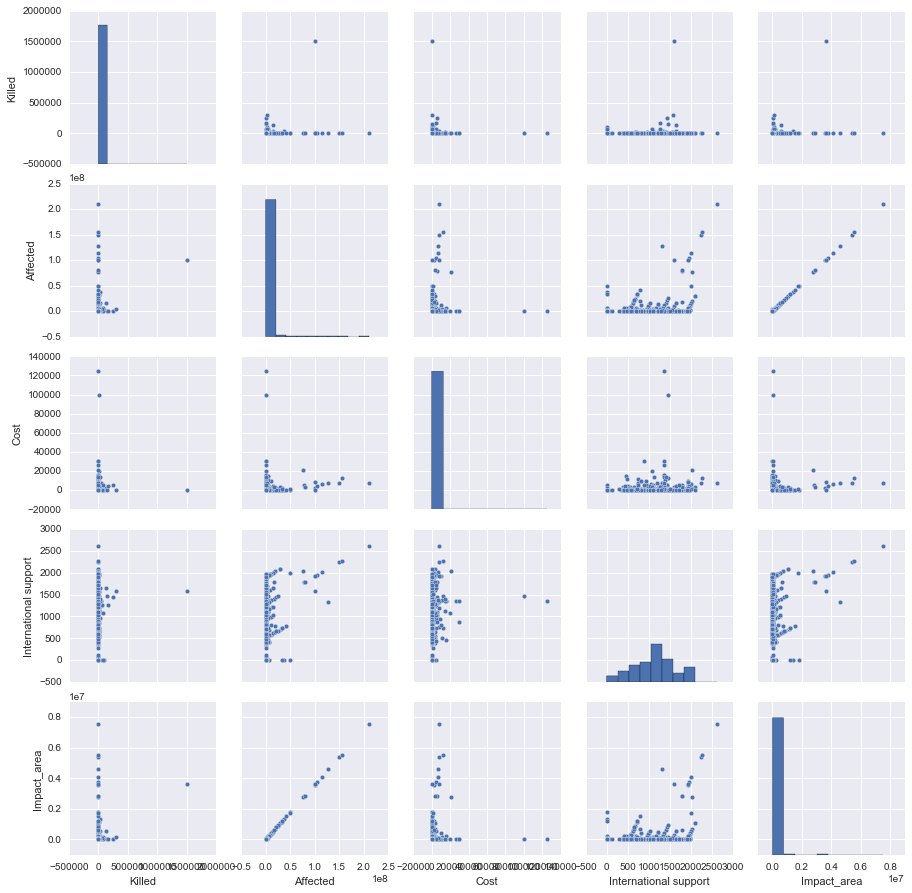

In [38]:
# Pair plot function helps to visualise correlation between numeric attributes
plotdf = disaster_alterdf[['Killed','Affected','Cost','International support','Impact_area']]
sns.pairplot(plotdf.dropna())

Observations:
> - Since Impact_area is a response variable, Affected attribute has a strong positive correlation
- International support attribute also having a association with Impact_area but surrounded by lot of noise

### Non-statistical method

In [ ]:
disaster_alterdf.describe(include=['O'])  

Conclusions:
> - China has high frequency of disaster registered in the dataset
- Transport Accident type has more frequency in the dataset

### Finding outliers of number people killed in South Africa for each type of disaster

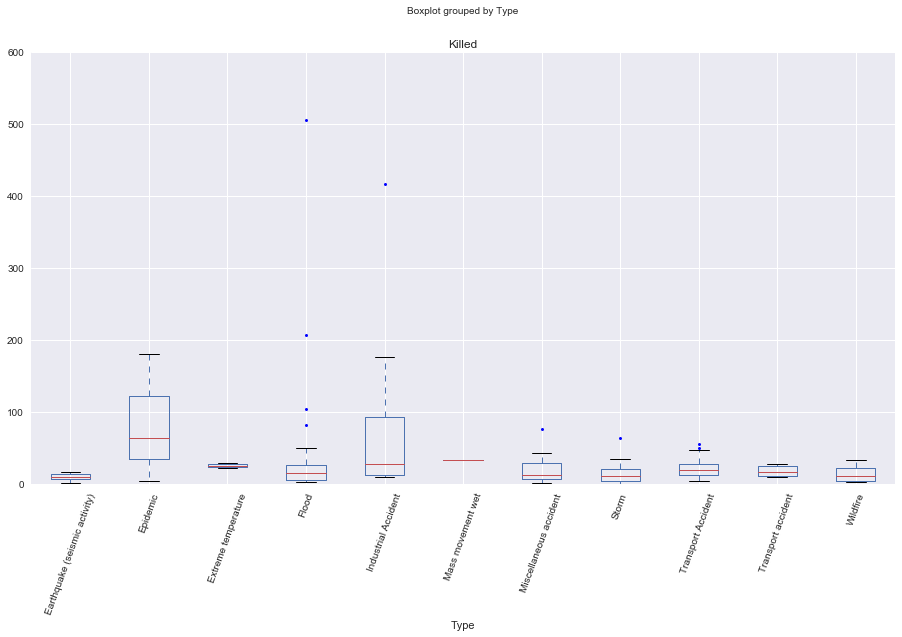

In [27]:
#Extracting dataframe where country is 'South Africa'
temp1=disaster_alterdf[disaster_alterdf.Country=='South Africa']
#NaNs will affect boxplot, so removing them
temp1=temp1[~temp1.Killed.isnull()]
#Box plotting Killed column grouped by type
temp1.boxplot(column='Killed', by='Type', sym='k.',figsize=(15,8),rot='70')

From the above boxplot,the ouliers can be seen for the following types Flood,Industrial Accident, Misc. Accident,Storm and Transport Accident.

### Using Hampel Identifier

Hampel Identifier(Median Absolute Deviation/MAD) is calculated using the formula: 
MAD=median(i)( ∣∣X(i)–median(j)(X(j)∣∣ )
Since this is more resilient to outliers,let us apply MAD to Killed column and box plot.

In [28]:
#converting the dataframe to array to perform the MAD function below.
killedarray=temp1.Killed.values
#finding the median of the killed column
median=temp1.Killed.median()
median

19.0

In [29]:
from math import fabs #to find absolute values
killedcolumn=[]
for a in killedarray:
    mad = fabs(a - median) #applying the formula for MAD
    killedcolumn.append(mad)
cleanedkilledcolumn=pd.DataFrame(killedcolumn)

In [30]:
#Dropping and adding the MAD-applied 'Killed' column to the dataframe 
temp1=temp1.reset_index(drop=True)
temp1.Killed=cleanedkilledcolumn.copy()

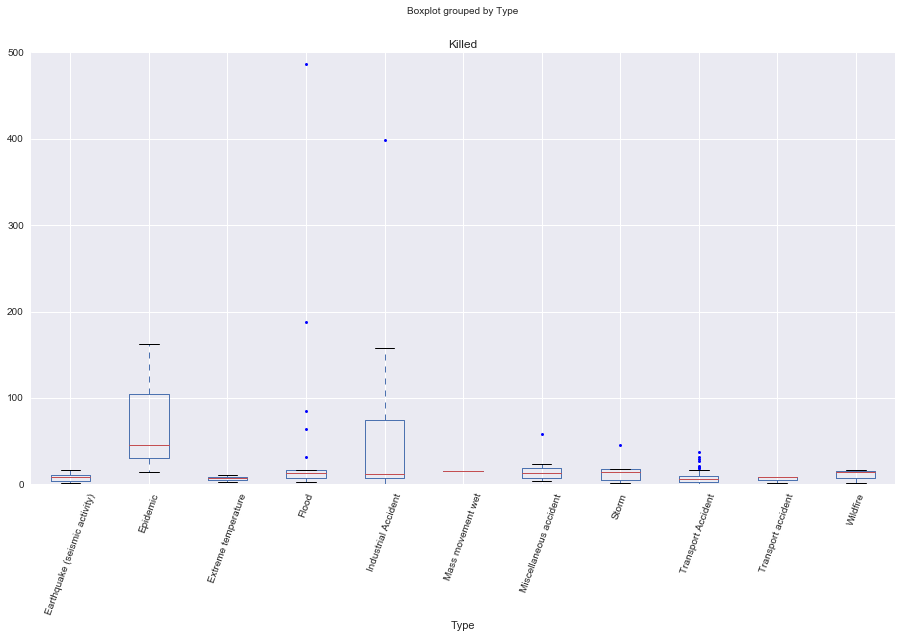

In [31]:
temp1.boxplot(column='Killed', by='Type', sym='k.',figsize=(15,8),rot='70')

From the above box plots, we can again see the same outliers but the entire range of the dataset has gone a little down but that does not affect the outliers in any way. So, let us have a look at types having outliers to check if they are genuine.

In [ ]:
#type 'Flood' has more outliers so looking at the dataset
temp1[temp1.Type=='Flood']

We can see the outliers 487,188,85 & 64. These can be legitimate values because the death toll of a flood can possibly have these values. Let us check one outlier for an instance.
The flood which happened in [Natal Province](http://articles.latimes.com/1987-10-10/news/mn-8582_1_south-african) in South Africa has a estimated death toll over 400. So, the value is genuine.

Let us check another instance in Industrial Accident.

In [ ]:
temp1[temp1.Type=='Industrial Accident']

Looking at the outlier 398, the [coalbrook disaster](http://www.eskom.co.za/OurCompany/90YearCelebrations/Pages/Decade_4.aspx) actually killed more than 400. Since the value is brought down by MAD, the entered value is correct.
So, the top most outliers in the box plot are valid and genuine.

## Task 3 - Dealing with missing data
### Task 3.1 - Deletion

In [ ]:
#Determining the number of missing values in the dataset
disaster_alterdf.isnull().sum()

From the above statistics, Cost column has 11323 out of 14350(79%) rows missing. There is no proper collection of data to replace the missing values. Hence, it is good to compromise the Cost column.

In [ ]:
#Dropping the 'Cost' column
disaster_alterdf.drop('Cost',1,inplace=True)

### Task 3.2 - Imputation using Linear Regression
Imputing the 'Impact_area' column using linear regression method.

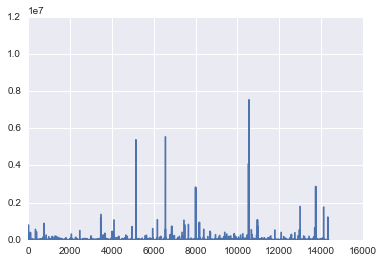

In [32]:
#Plotting the impact_area column to see the range of values in the dataset.
plt.plot(originaldisasterdf.Impact_area)

The above plot shows that the data is messy and has a wide range.

In [33]:
#Finding the number of missing values
originaldisasterdf[originaldisasterdf.Impact_area.isnull()].shape

(7422, 13)

### Deciding on the range of values needed for training the dataset

In [34]:
#selecting the dataframe required for training the model
regessiondf=originaldisasterdf[['Country','Type','Killed','Affected','Impact_area']]
#Since it is for regression, selecting the not null values for training
regessiondf=regessiondf[regessiondf.Impact_area.isnull()==False]
regessiondf

,Country,Type,Killed,Affected,Impact_area
1,Japan,Storm,61.0,30000.0,1074.46
2,Grenada,Storm,39.0,60000.0,2162.03
4,Cuba,Flood,15.0,164575.0,5893.45
7,Turkey,Miscellaneous accident,10.0,13.0,5.29
8,Pakistan,Storm,51.0,2557.0,130.70
10,Colombia,Industrial Accident,22.0,24.0,31.56
15,Canada,Transport Accident,22.0,11.0,11.32
17,India,Flood,867.0,22000000.0,787257.62
18,Viet Nam,Storm,46.0,58511.0,2116.61
19,Bangladesh,Storm,15.0,100.0,32.19


One condition to perform regression is to have no missing values in the training set. There are no missing values for the four attributes where impact area value is present.

In [35]:
#selecting 75% percent of the availabe data to reduce the range of values
regessiondf[(regessiondf.Impact_area>1)&(regessiondf.Impact_area<1000)].shape

(5281, 5)

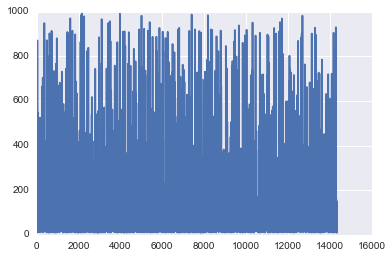

In [36]:
#Plotting the new range of data
regessiondf=regessiondf[(regessiondf.Impact_area>10)&(regessiondf.Impact_area<1000)]
plt.plot(regessiondf.Impact_area)

The above plot when compared to the first plot of this section has been tidied a bit and the range is close now.

In [37]:
#implementing the provided code for training the model
import regression
#training the model and getting a standard error value
trainedModel = regression.train(df = regessiondf)

Standard error: 12.61


This is the minimum Standard Error achieved by training the model.

## Predicting the values

In [ ]:
# Since prediction cannot be done with missing values, imputing the columns with mean
disaster_alterdf.Killed.fillna(0,inplace=True)
disaster_alterdf.Affected.fillna(0,inplace=True)
#selecting dataframe for prediction
predictiondf=disaster_alterdf[['Country','Type','Killed','Affected','Impact_area']]
#selecting rows which have missing value
predictiondf=predictiondf[predictiondf.Impact_area.isnull()]
predictiondf

In [ ]:
#running the given prediction model
predictedValues = regression.predict(model = trainedModel , df = predictiondf)
predictedValues

In [ ]:
#checking the count of predictedValues
len(predictedValues)

In [ ]:
#replacing the impact area of the original dataset with the predicted values
disaster_alterdf.Impact_area[disaster_alterdf['Impact_area'].isnull()]=predictedValues.copy()

In [ ]:
disaster_alterdf

The impact area values are in scientific notation. Inorder to bring them to proper float values with 3 decimal points. We use set_option function of pandas and apply lambda function to take only 3 decimal points.

In [ ]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
(disaster_alterdf.Impact_area)*10

### Writing the cleaned data to a csv file

In [ ]:
disaster_alterdf.to_csv("data_cleaned.csv",sep=',')